# MLP Classifier for IRIS Dataset\n\nThis notebook implements comprehensive training and evaluation.

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPClassifier

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Dataset

In [5]:
df = pd.read_csv('../models/cleaned_iris_dataset.csv')
X = df.drop('species', axis=1)
y = df['species']
print(f'Dataset Shape: {df.shape}')
print(f'Features: {list(X.columns)}')
print(f'Classes: {sorted(y.unique())}')

Dataset Shape: (149, 5)
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Classes: [0, 1, 2]


## 2. Train-Test Split & Scaling

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f'Training set: {X_train.shape[0]} samples')
print(f'Testing set: {X_test.shape[0]} samples')

Training set: 119 samples
Testing set: 30 samples


## 3. Model Training with Hyperparameter Tuning

In [7]:
from sklearn.neural_network import MLPClassifier

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}

# GridSearchCV
grid_search = GridSearchCV(
    MLPClassifier(random_state=42, early_stopping=True),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print('Starting hyperparameter tuning for MLP Classifier...')
grid_search.fit(X_train_scaled, y_train)

mlp_best = grid_search.best_estimator_
print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best CV score: {grid_search.best_score_:.4f}')
print(f'Test accuracy: {mlp_best.score(X_test_scaled, y_test):.4f}')

Starting hyperparameter tuning for MLP Classifier...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Best CV score: 0.8486
Test accuracy: 0.8000


## 4. Model Evaluation

Test Accuracy: 0.8000
\nClassification Report:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       0.83      0.50      0.62        10
   Virginica       0.64      0.90      0.75        10

    accuracy                           0.80        30
   macro avg       0.83      0.80      0.79        30
weighted avg       0.83      0.80      0.79        30



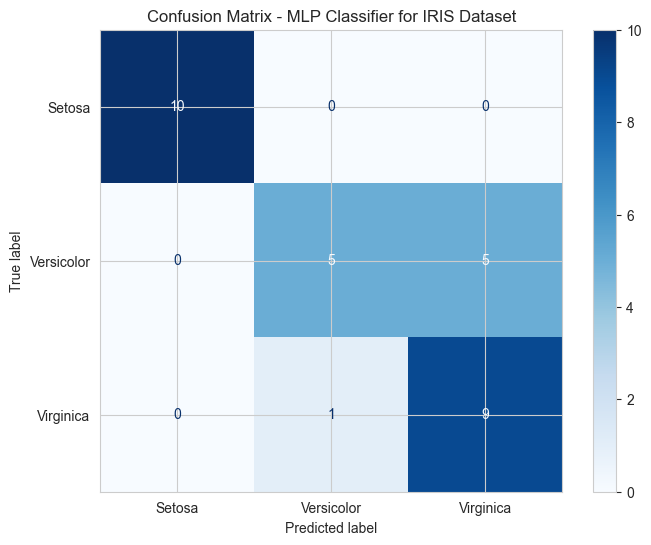

In [8]:
species_names = ['Setosa', 'Versicolor', 'Virginica']
y_test_pred = mlp_best.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\\nClassification Report:')
print(classification_report(y_test, y_test_pred, target_names=species_names))
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix - MLP Classifier for IRIS Dataset')
plt.show()

## Training Loss Curve

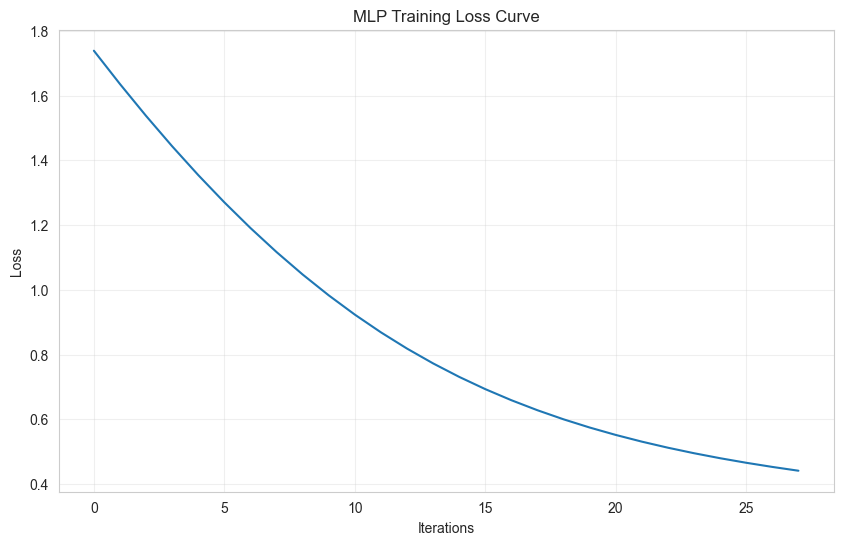

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(mlp_best.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Model Inference

In [10]:
new_samples = np.array([[5.1, 3.5, 1.4, 0.2], [6.2, 2.9, 4.3, 1.3], [7.3, 2.9, 6.3, 1.8]])
new_samples_scaled = scaler.transform(new_samples)
predictions = mlp_best.predict(new_samples_scaled)
probabilities = mlp_best.predict_proba(new_samples_scaled)
for i, (sample, pred, proba) in enumerate(zip(new_samples, predictions, probabilities)):
    print(f'Sample {i+1}: {sample} -> {species_names[pred]} (confidence: {proba[pred]:.4f})')

Sample 1: [5.1 3.5 1.4 0.2] -> Setosa (confidence: 0.7416)
Sample 2: [6.2 2.9 4.3 1.3] -> Versicolor (confidence: 0.3990)
Sample 3: [7.3 2.9 6.3 1.8] -> Virginica (confidence: 0.4901)


## 6. Save Model

In [11]:
model_data = {'model': mlp_best,
             'scaler': scaler,
              'feature_names': list(X.columns),
               'class_names': species_names,
                'test_accuracy': test_accuracy}
with open('../models/mlp_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print('✓ Model saved to ../models/mlp_model.pkl')

✓ Model saved to ../models/mlp_model.pkl
